# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).


In [1]:
from scipy import misc, ndimage, datasets
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams["figure.figsize"] = (12, 6)

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.


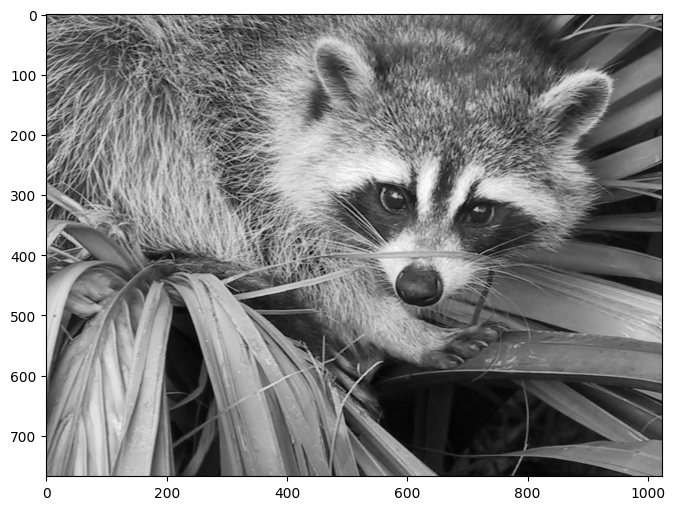

In [2]:
X = datasets.face(gray=True)
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata Fourier a unei imagini

Transformata Fourier Discretă se extinde ușor la mai multe dimensiuni. Pentru un semnal bidimensional precum o imagine DFT devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}x_{n_1,n_2}e^{-j2\pi(m_1 n_1/N_1 + m_2 n_2/N_2)}
$$

- unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
- bin-urile rezultate corespund pozițiilor pixelilor
- spectrul este în continuare simetric
- proprietățile transformatei DFT 1D sunt respectate și în cazul celei 2D

În continuare vom folosi rutina generală `fft2` ce servește mai bine activității de învățare, deși pentru semnale reale ar trebui să folosim `rfft2` ce întoarce doar informația esențială (ex. omite simetriile). De asemenea vom analiza spectrul în scală logaritmică pentru a diferenția mai bine magnitudinile bin-urilor DTF.


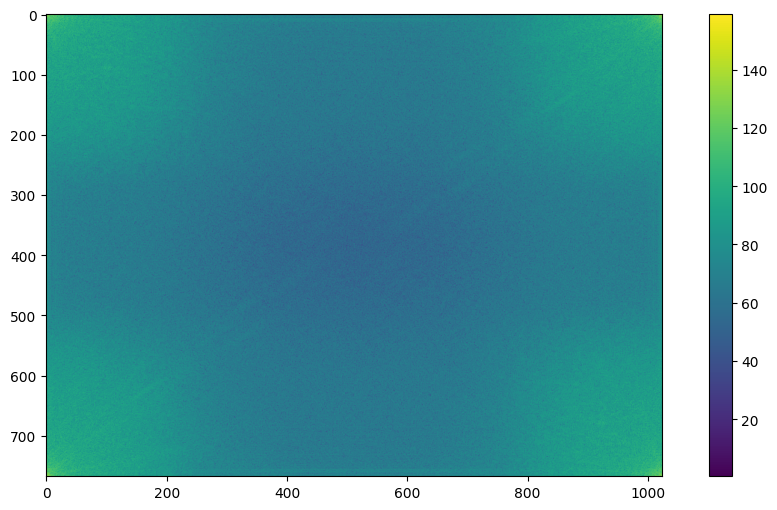

In [3]:
Y = np.fft.fft2(X)
freq_db = 20 * np.log10(abs(Y))

plt.imshow(freq_db)
plt.colorbar()
plt.show()

Operațiile efectuate direct asupra imaginii se reflectă și în spectrul acesteia. Iată un exemplu a unei rotații de 45 de grade:


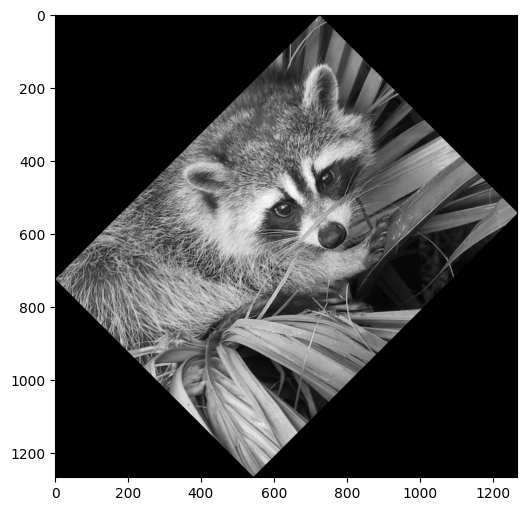

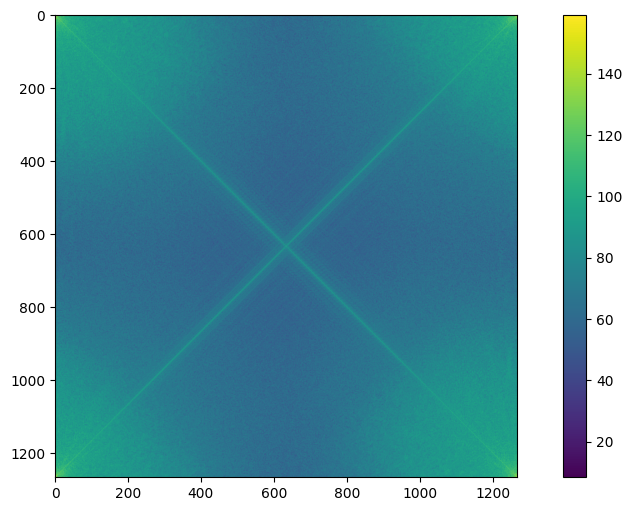

In [4]:
rotate_angle = 45
X45 = ndimage.rotate(X, rotate_angle)
plt.imshow(X45, cmap=plt.cm.gray)
plt.show()

Y45 = np.fft.fft2(X45)
plt.imshow(20 * np.log10(abs(Y45)))
plt.colorbar()
plt.show()

Momentan pe axe sunt afișate numărul bin-urilor. Pentru a obține frecvențele asociate folosiți `fftfreq`:


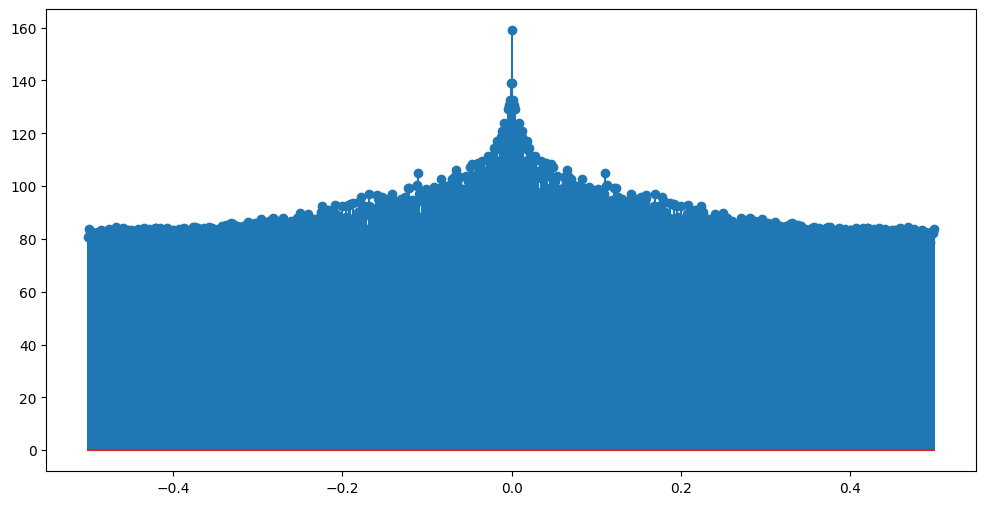

In [5]:
freq_x = np.fft.fftfreq(X.shape[1])
freq_y = np.fft.fftfreq(X.shape[0])

plt.stem(freq_x, freq_db[:][0])
plt.show()

# Atenuarea frecvențelor înalte

Pentru a anula frecvențele de peste un anumit prag `freq_cutoff` putem pur și simplu anula intrările din spectru și aplica transformata Fourier inversă:


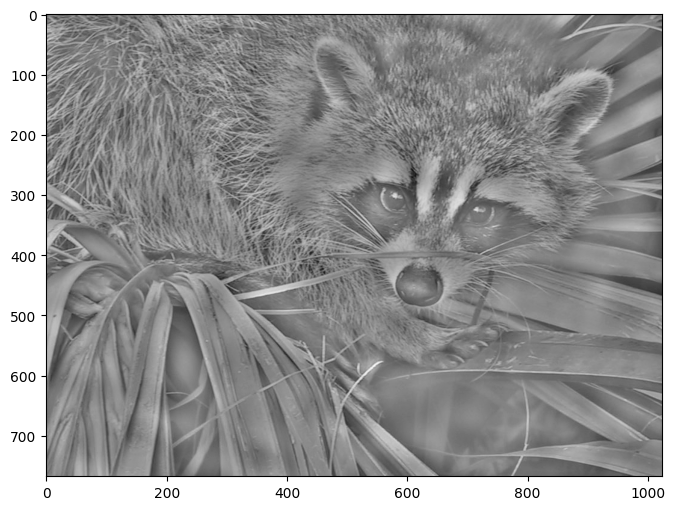

In [6]:
freq_cutoff = 120

Y_cutoff = Y.copy()
Y_cutoff[freq_db > freq_cutoff] = 0
X_cutoff = np.fft.ifft2(Y_cutoff)
X_cutoff = np.real(X_cutoff)  # avoid rounding erros in the complex domain,
# in practice use irfft2
plt.imshow(X_cutoff, cmap=plt.cm.gray)
plt.show()

# Zgomot

Zgomotul alb perturbă în mod egal spectrul semnalului. Este astfel egal distribuit și regăsit în toate bin-urile DFT. [Zgomotul color](https://en.wikipedia.org/wiki/Colors_of_noise) se schimbă de-a lungul frecvențelor.

Putem adăuga zgomot în limita a `pixel_noise` pixeli imaginii folosind `random.randint`:


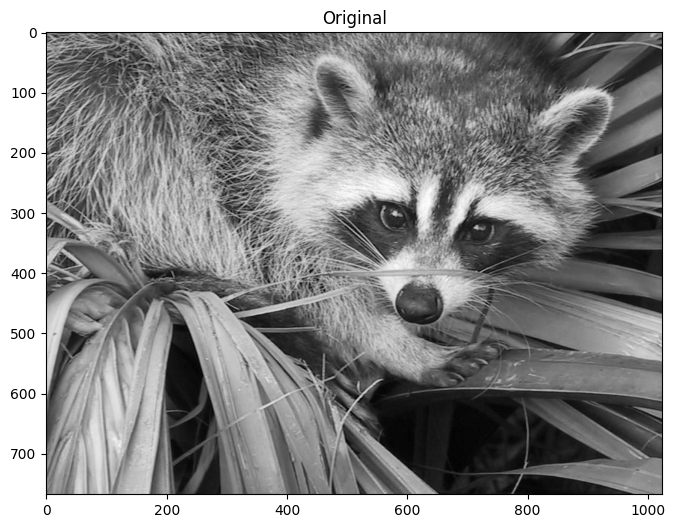

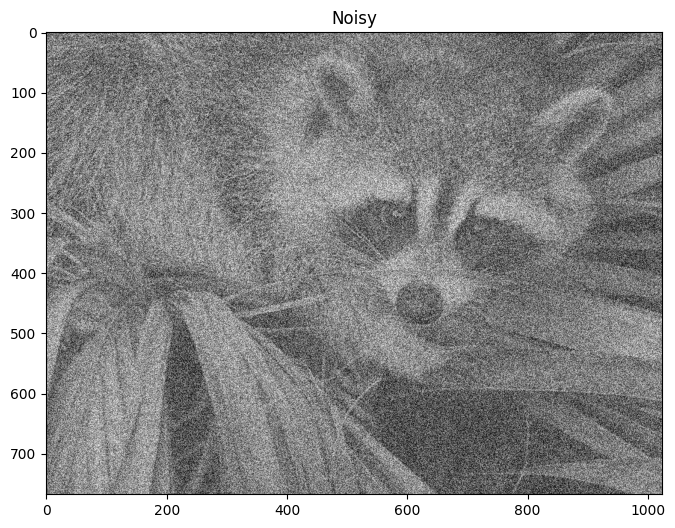

In [7]:
pixel_noise = 200

noise = np.random.randint(-pixel_noise, high=pixel_noise + 1, size=X.shape)
X_noisy = X + noise
plt.imshow(X, cmap=plt.cm.gray)
plt.title("Original")
plt.show()
plt.imshow(X_noisy, cmap=plt.cm.gray)
plt.title("Noisy")
plt.show()

# Sarcini

1. Produceți imaginile și spectrul pentru funcțiile de mai jos și dați o explicație scurtă pentru fiecare rezultat.

- $x_{n_1,n_2} = \sin(2\pi n_1 + 3\pi n_2)$
- $x_{n_1,n_2} = \sin(4\pi n_1) + \cos(6\pi n_2)$
- $Y_{0,5} = Y_{0,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
- $Y_{5,0} = Y_{N-5,0} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
- $Y_{5,5} = Y_{N-5,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

_Atenție_: $x$ reprezintă informație în domeniul timpului, $Y$ în domeninul frecvenței.

2. Comprimați imaginea cu ratonul de mai sus prin atenuarea frecvențelor înalte până la un prag SNR autoimpus.

3. Eliminați zgomotul adăugat la imaginea cu ratonul produsă mai sus. Prezentați raportul SNR înainte și după.


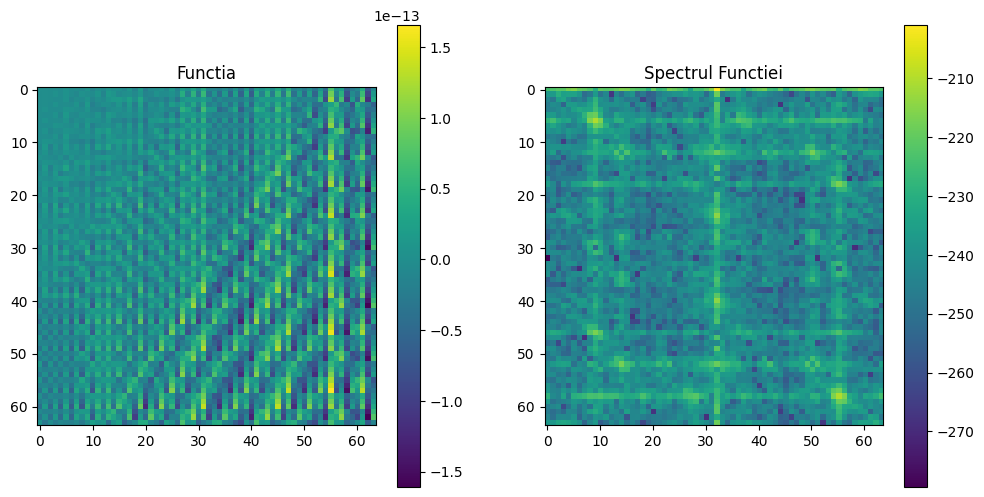

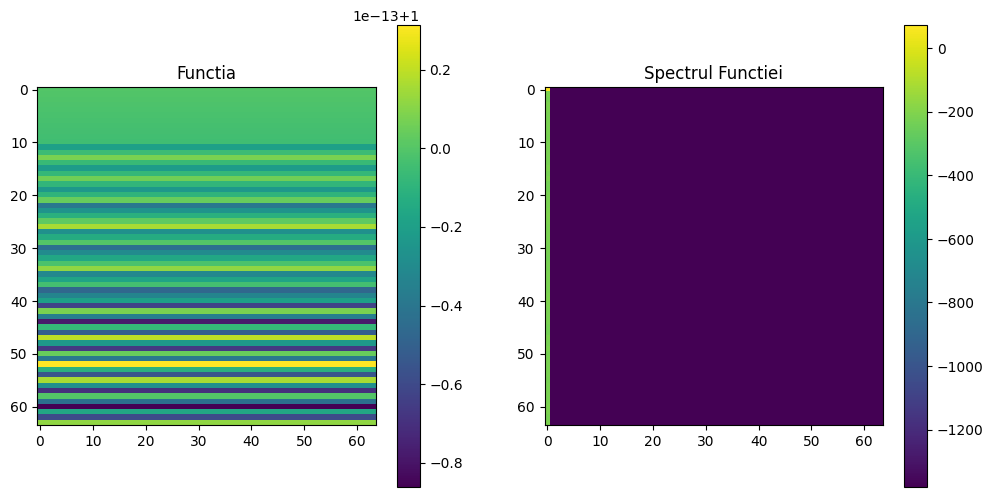

In [8]:
# 1. Produceți imaginile și spectrul pentru funcțiile de mai jos și dați o explicație scurtă pentru fiecare rezultat.

n1, n2 = 64, 64


def plot_img_and_spectrum(X=None, Y=None, name="Title"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    if Y is None:
        Y = 20 * np.log10(abs(np.fft.fft2(X)) + 1e-69)
    elif X is None:
        X = np.fft.ifft2(Y)

    axs[1].imshow(Y), axs[1].set_title("Spectrul Functiei")
    fig.colorbar(axs[1].imshow(Y), ax=axs[1])

    axs[0].imshow(np.real(X)), axs[0].set_title("Functia")
    fig.colorbar(axs[0].imshow(np.real(X)), ax=axs[0])

    plt.show()


def create_and_plot_from_signal(func):
    i, j = np.indices((n1, n2))
    x = func(i, j)
    plot_img_and_spectrum(X=x)


# 1.1
create_and_plot_from_signal(lambda i, j: np.sin(2 * np.pi * i + 3 * np.pi * j))
# 1.2
create_and_plot_from_signal(lambda i, j: np.sin(4 * np.pi * i) + np.cos(6 * np.pi * j))

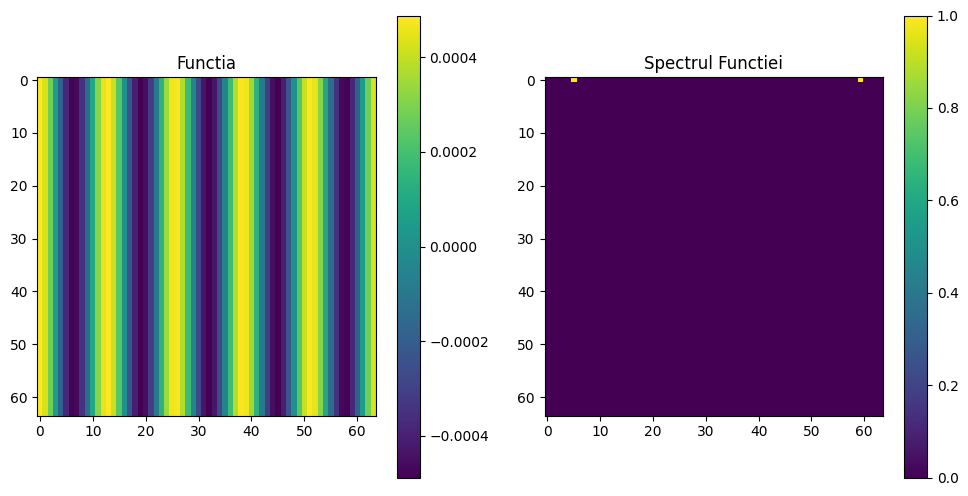

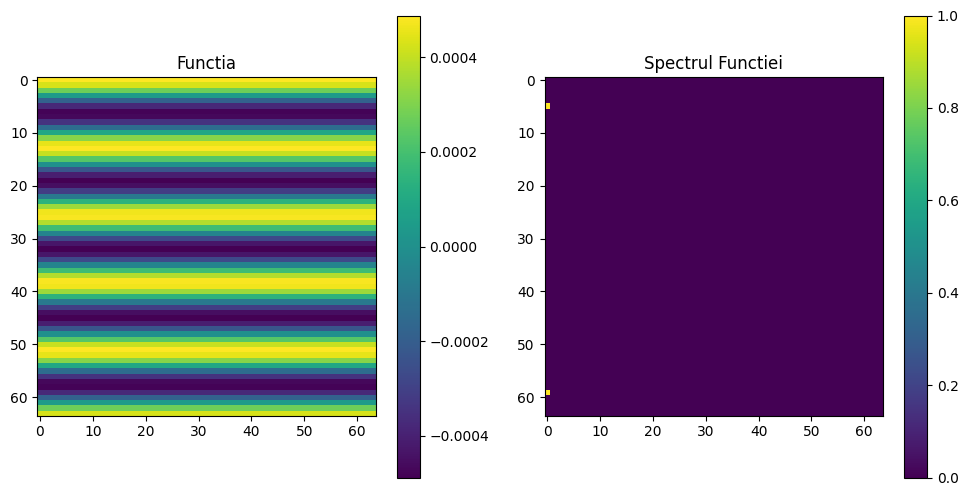

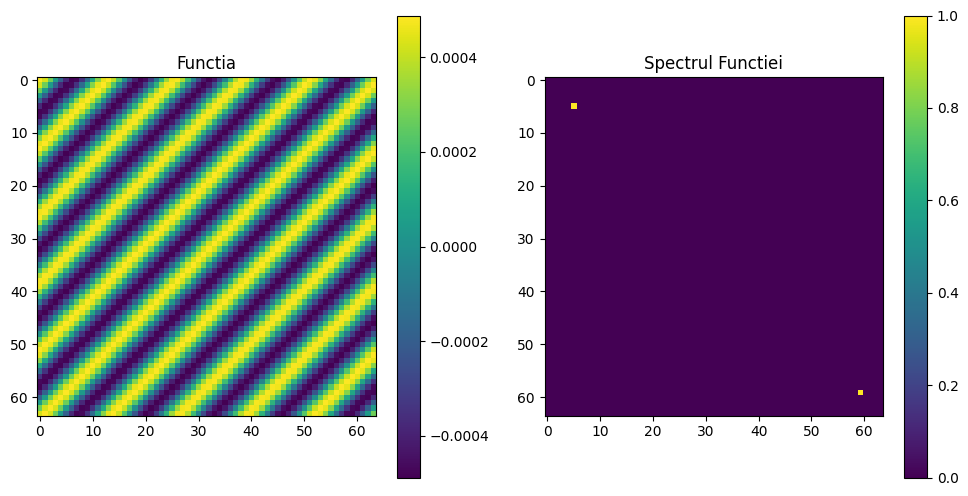

In [9]:
def create_and_plot_from_spectrum(coords):
    Y = np.zeros((n1, n2))
    for coord in coords:
        Y[coord] = 1
    plot_img_and_spectrum(Y=Y)


create_and_plot_from_spectrum([(0, 5), (0, -5)])
create_and_plot_from_spectrum([(5, 0), (-5, 0)])
create_and_plot_from_spectrum([(5, 5), (-5, -5)])

Step 0: SNR = inf
Step 1: SNR = 0.48596336082893415
Step 2: SNR = 0.2989208523768484
Step 3: SNR = 0.23753700727827265
Step 4: SNR = 0.18696072655096588
Step 5: SNR = 0.14796268958524128
Step 6: SNR = 0.12806678116022496
Step 7: SNR = 0.1121923041175761
Step 8: SNR = 0.10039015026608442
Step 9: SNR = 0.09708643953976089


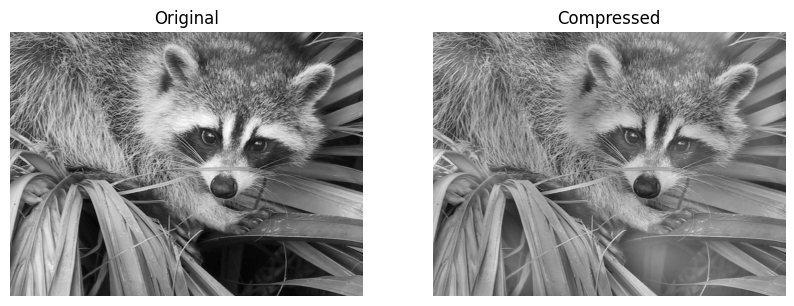

In [10]:
# 2. Comprimați imaginea cu ratonul de mai sus prin atenuarea frecvențelor înalte până la un prag SNR autoimpus.
X = datasets.face(gray=True)

snr_threshold = 0.1


def calculate_snr(original, compressed):
    noise = original - compressed
    mse = np.mean((noise) ** 2)
    if mse == 0:
        return np.inf
    return np.mean(X**2) / mse


def attenuate_highest(Z, annealing_factor):
    Y = np.fft.fft2(Z)
    dc = Y[0, 0]
    Y[0, 0] = 0
    threshold = np.max(np.abs(Y)) * annealing_factor
    Y[np.abs(Y) >= threshold] *= 0.1
    Y[0, 0] = dc
    return np.real(np.fft.ifft2(Y))


def show_freqs(Z):
    Y = np.fft.fft2(Z)

    freq_x = np.fft.fftfreq(Z.shape[1])
    freq_db = 20 * np.log10(abs(Y))
    plt.stem(freq_x, freq_db[:][0])
    plt.show()


Z = X.copy()
for step in range(200):
    current_snr = calculate_snr(X, Z)
    print(f"Step {step}: SNR = {current_snr}")
    # show_freqs(Z)
    if current_snr <= snr_threshold:
        break
    Z = attenuate_highest(Z, 0.9)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(X, cmap="gray"), axs[0].axis("off"), axs[0].set_title("Original")
axs[1].imshow(Z, cmap="gray"), axs[1].axis("off"), axs[1].set_title("Compressed")
plt.show()

SNR: 0.007947219091245619
SNR: 0.24510012068597942


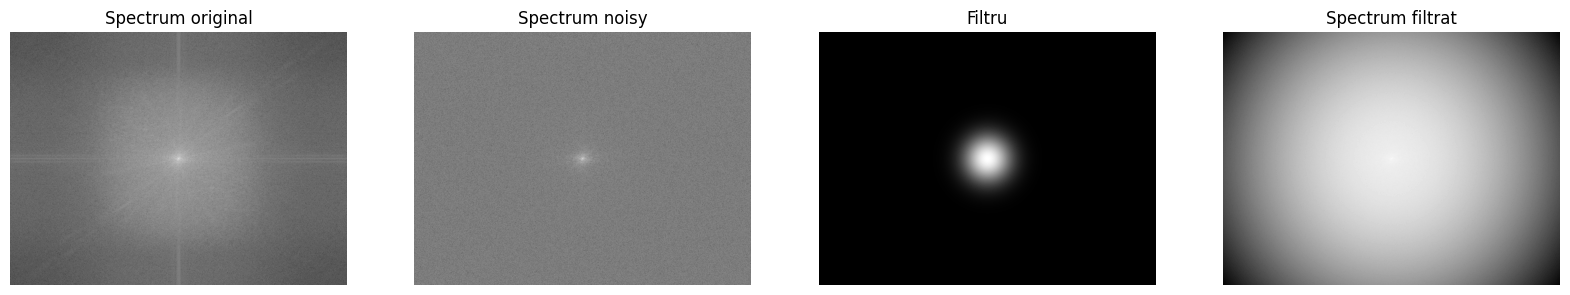

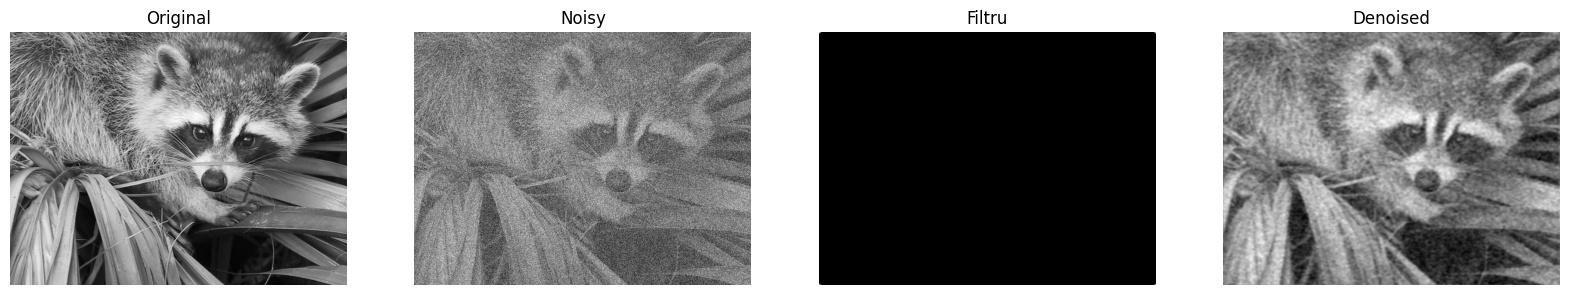

In [11]:
# 3. Eliminați zgomotul adăugat la imaginea cu ratonul produsă mai sus. Prezentați raportul SNR înainte și după.
#  ratonul meu Z sau ratonul X_cutoff?
def generate_2d_gaussian_kernel(height, width, sigma):
    kernel = np.zeros((height, width))
    center = (height // 2, width // 2)
    for i in range(height):
        for j in range(width):
            kernel[i, j] = np.exp(
                -((i - center[0]) ** 2 + (j - center[1]) ** 2) / (2 * sigma**2)
            )

    return kernel


def plot_image(ax, image, title, cmap="gray"):
    ax.imshow(image, cmap=cmap)
    ax.axis("off")
    ax.set_title(title)


print(f"SNR: {calculate_snr(X, X_noisy)}")
Y = np.fft.fftshift((np.fft.fft2(X)))
Y_noisy = np.fft.fftshift((np.fft.fft2(X_noisy)))


filtru = generate_2d_gaussian_kernel(Y.shape[0], Y.shape[1], 50)
Y_denoised = Y_noisy * filtru

fig, axs = plt.subplots(1, 4, figsize=(20, 4))

plot_image(axs[0], 20 * np.log(np.abs(Y)), "Spectrum original")
plot_image(axs[1], 20 * np.log(np.abs(Y_noisy)), "Spectrum noisy")
plot_image(axs[2], filtru, "Filtru")
plot_image(axs[3], 20 * np.log(np.abs(Y_denoised)), "Spectrum filtrat")


X_denoised = np.real(np.fft.ifft2(np.fft.ifftshift(Y_denoised)))
print(f"SNR: {calculate_snr(X, X_denoised)}")

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_image(axs[0], X, "Original")
plot_image(axs[1], X_noisy, "Noisy")
plot_image(axs[2], np.real(np.fft.ifft2(np.fft.ifftshift(filtru))), "Filtru")
plot_image(axs[3], X_denoised, "Denoised")

plt.show()

SNR scipy: 0.033893922606966505
SNR cv: 1.0033049837604204


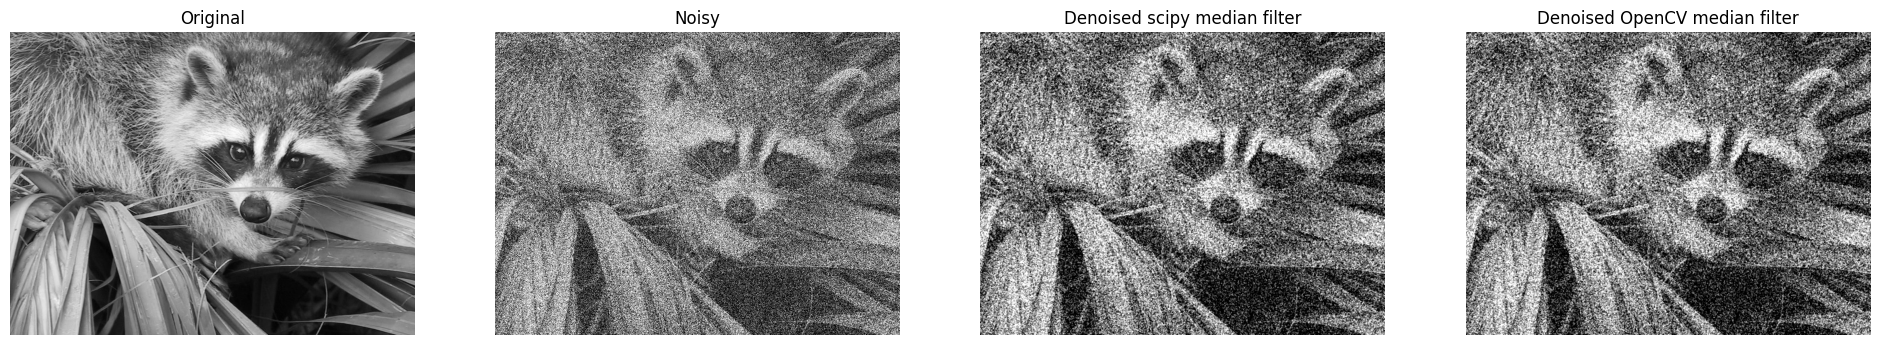

In [12]:
# median filtering
X_noisy = X_noisy.clip(0, 255)  # asta ajuta foarte mult pe openCV dar nu pe scipy huh

X_denoised = ndimage.median_filter(X_noisy, size=3)
print(f"SNR scipy: {calculate_snr(X, X_denoised)}")

X_denoised_cv = cv2.medianBlur(X_noisy.astype(np.uint8), ksize=3)
print(f"SNR cv: {calculate_snr(X, X_denoised_cv)}")

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plot_image(axs[0], X, "Original")
plot_image(axs[1], X_noisy, "Noisy")
plot_image(axs[2], X_denoised, "Denoised scipy median filter")
plot_image(axs[3], X_denoised_cv, "Denoised OpenCV median filter")